# Course Project

### Corpus information

- Description of the chosen corpus: Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness and surprise.
- Link to corpus: https://huggingface.co/datasets/dair-ai/emotion
- Paper(s) and other published materials related to the corpus: **CARER: Contextualized Affect Representations for Emotion Recognition**
- State-of-the-art performance (best published results) on this corpus: finetuned BERT and DistilRoBERTa with accuracy approx. 0.94

---

## 1. Setup

In [1]:
# !pip install datasets

In [2]:
from datasets import load_dataset
import numpy as np
import torch
import math

In [3]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

---

## 2. Data download and preprocessing

### 2.1. Download the corpus

In [4]:
dataset = load_dataset("dair-ai/emotion")

/home/lauri/miniconda3/envs/ihlt/lib/python3.12/site-packages/datasets/load.py:1461: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


### 2.2. Preprocessing

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [13]:
from more_itertools import sliding_window

In [14]:
def create_vocab(data):
    vocabulary = {}
    vocabulary['<none>'] = 0

    i = len(vocabulary)
    for string in data['text']:
        arr = string.split()
        for t in arr:
            if not t in vocabulary:
                vocabulary[t] = i
                i += 1
    return vocabulary

def tokenize_data(vocab, data):
    tokenized = []
    strings = [t for t in data['text']]
    for s in strings:
        arr = []
        split_s = s.split()
        for t in split_s:
            if t in vocab:
                arr.append(vocab[t])
            else:
                arr.append(vocab['<none>'])
        tokenized.append(arr)
    return tokenized

def one_hot_encode_sum(arr, unique):
    a = np.array(arr)
    b = np.zeros((a.size, unique))
    b[np.arange(a.size), a] = 1
    return b.sum(axis=0)

def one_hot_encode(i, unique):
    a = np.zeros(unique)
    a[i] = 1.0
    return a

def encode_cbows(tokenized, unique, window):
    x = []
    y = []
    half = int(window / 2)
    for sentence in tokenized:
        for subset in sliding_window(sentence, window):
            x.append(one_hot_encode_sum(subset[:half] + subset[half+1:], unique))
            y.append(one_hot_encode(subset[half], unique))
    return np.array(x, dtype=np.uint8), np.array(y, dtype=np.uint8)

In [15]:
vocab = create_vocab(dataset['train'])

In [21]:
def create_cbows(tokenized, unique, window):
    x = []
    y = []
    half = int(window / 2)
    for sentence in tokenized:
        for subset in sliding_window(sentence, window):
            x.append(subset[:half] + subset[half+1:])
            y.append(subset[half])
    return x, y

In [22]:
tokenized_train = tokenize_data(vocab, dataset['train'])
x_train, y_train = create_cbows(tokenized_train, len(vocab), 5)

tokenized_validation = tokenize_data(vocab, dataset['validation'])
x_validation, y_validation = create_cbows(tokenized_validation, len(vocab), 5)

In [39]:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
from torch.utils.data import Dataset, DataLoader

class CustomDataloader3(Dataset):
    def __init__(self, x, y, unique):
        self.size = len(x)
        # make sure data is batch aligned
        self.x = x
        self.y = y
        self.unique = unique

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if (idx >= self.size):
            raise IndexError
    
        x_tmp = one_hot_encode_sum(self.x[idx], self.unique)
        y_tmp = one_hot_encode(self.y[idx], self.unique)
        
        x_final = torch.tensor(np.array(x_tmp, dtype=np.float32))
        y_final = torch.tensor(np.array(y_tmp, dtype=np.float32))
        
        return x_final, y_final

In [40]:
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_dataset = CustomDataloader3(x_train, y_train, len(vocab))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, prefetch_factor=8)
train_eval_dataloader = DataLoader(train_dataset, batch_size=512, num_workers=4)
validation_dataset = CustomDataloader3(x_validation, y_validation, len(vocab))
validation_dataloader = DataLoader(validation_dataset, batch_size=512)

In [16]:
# TODO: understand wtf is happening
# link: https://medium.com/@enozeren/word2vec-from-scratch-with-python-1bba88d9f221
class Word2Vec(torch.nn.Module):
    def __init__(self, VOCAB_SIZE, VECTOR_DIM) -> None:
        super().__init__()

        self.vocab_size = VOCAB_SIZE
        self.vector_dim = VECTOR_DIM
        self.W1 = torch.nn.Parameter(data=torch.randn(self.vocab_size, self.vector_dim), requires_grad=True)
        torch.nn.init.uniform_(self.W1,-0.001,0.001)
        self.A1 = torch.nn.Softmax(dim=1)
        self.W2 = torch.nn.Parameter(data=torch.randn(self.vector_dim, self.vocab_size), requires_grad=True)

    def forward(self, X) -> torch.tensor:
        X = X @ self.W1
        X = self.A1(X)
        X = X @ self.W2

        return X

In [45]:
model = Word2Vec(len(vocab), 64).to(dev)

In [66]:
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [60]:
def train_loop(dataloader, __model, loss_fn, optimizer):
    size = len(dataloader)
    __model.train()
    for batch, (X, Y) in enumerate(dataloader):
        pred = __model(X.to(dev))
        loss = loss_fn(pred, Y.to(dev))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def training_eval(history, dataloader, __model, loss_fn):
    __model.eval()
    size = len(dataloader) * dataloader.batch_size
    num_batches = len(dataloader)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, Y in dataloader:
            pred = __model(X.to(dev))
            # print(f"pred.size {pred.size()}, X.size {X.size()}, Y.size {Y.size()}")
            _Y = Y.to(dev)
            loss += loss_fn(pred, _Y).item()
            correct += (pred.argmax(dim=1) == _Y.argmax(dim=1)).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    # print(f"Test Error: Accuracy: {(100*(correct)):>0.1f}%, Avg loss: {loss:>8f}")

    history['train_loss'].append(loss)
    history['train_acc'].append(correct)

def validation_eval(history, dataloader, __model, loss_fn):
    __model.eval()
    size = len(dataloader) * dataloader.batch_size
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, Y in dataloader:
            pred = __model(X.to(dev))
            # print(f"pred.size {pred.size()}, X.size {X.size()}, Y.size {Y.size()}")
            _Y = Y.to(dev)
            test_loss += loss_fn(pred, _Y).item()
            correct += (pred.argmax(dim=1) == _Y.argmax(dim=1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: Accuracy: {(100*(correct)):>0.1f}%, Avg loss: {test_loss:>8f}")

    history['val_loss'].append(test_loss)
    history['val_acc'].append(correct)

In [68]:
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
}
for e in range(20):
    train_loop(train_dataloader, model, loss_fn, optimizer)
    training_eval(history, train_eval_dataloader, model, loss_fn)
    validation_eval(history, validation_dataloader, model, loss_fn)

    train_acc = history['train_acc'][-1]
    train_loss = history['train_loss'][-1]
    val_acc = history['val_acc'][-1]
    val_loss = history['val_loss'][-1]
    
    print(f"[Epoch {e}] Train Error: Accuracy: {(100*(train_acc)):>0.1f}%, Avg loss: {train_loss:>8f} | Val Error: Accuracy: {(100*(val_acc)):>0.1f}%, Avg loss: {val_loss:>8f}")

[Epoch 0] Train Error: Accuracy: 9.4%, Avg loss: 6.337802 | Val Error: Accuracy: 9.2%, Avg loss: 6.438581
[Epoch 1] Train Error: Accuracy: 12.1%, Avg loss: 6.029422 | Val Error: Accuracy: 11.7%, Avg loss: 6.234499
[Epoch 2] Train Error: Accuracy: 13.9%, Avg loss: 5.853112 | Val Error: Accuracy: 13.0%, Avg loss: 6.141729
[Epoch 3] Train Error: Accuracy: 15.2%, Avg loss: 5.705957 | Val Error: Accuracy: 13.8%, Avg loss: 6.061456
[Epoch 4] Train Error: Accuracy: 16.2%, Avg loss: 5.575885 | Val Error: Accuracy: 14.4%, Avg loss: 5.999232
[Epoch 5] Train Error: Accuracy: 17.3%, Avg loss: 5.457466 | Val Error: Accuracy: 15.0%, Avg loss: 5.952324
[Epoch 6] Train Error: Accuracy: 18.2%, Avg loss: 5.346476 | Val Error: Accuracy: 15.3%, Avg loss: 5.916493
[Epoch 7] Train Error: Accuracy: 19.0%, Avg loss: 5.241935 | Val Error: Accuracy: 15.5%, Avg loss: 5.889284
[Epoch 8] Train Error: Accuracy: 19.9%, Avg loss: 5.143111 | Val Error: Accuracy: 15.8%, Avg loss: 5.869103
[Epoch 9] Train Error: Accurac

In [69]:
import matplotlib.pyplot as plt

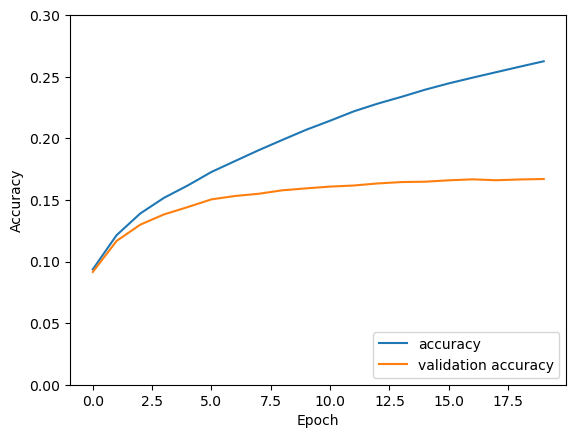

In [74]:
plt.plot(history['train_acc'], label='accuracy')
plt.plot(history['val_acc'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 0.3])
plt.legend(loc='lower right')

In [75]:
torch.save(model.state_dict(), 'model.torch')

In [46]:
model = Word2Vec(len(vocab), 64)
model.load_state_dict(torch.load('model.torch'))
model.eval()

Word2Vec(
  (A1): Softmax(dim=1)
)

In [47]:
# pad all the tokenized sentences to max
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [48]:
max_len0=max(len(t) for t in tokenized_train)
max_len1=max(len(t) for t in tokenized_validation)
max_len=max(max_len0, max_len1)
max_len

66

In [49]:
print(len(tokenized_validation[0]))
model.W1[tokenized_validation[0]].shape

15


torch.Size([15, 64])

In [50]:
t0=model.W1[tokenized_validation[0]].clone().detach()
torch.nn.functional.pad(t0, (0, 0, 0, max_len - t0.shape[0])).shape

torch.Size([66, 64])

In [51]:
def createDataset(embeddings, tokens, labels, max_len):
    tensors = []
    
    for t in tokens:
        tmp=embeddings[t].clone().detach()
        padded=torch.nn.functional.pad(tmp,(0, 0, 0, max_len-tmp.shape[0]))
        tensors.append(padded)
    X = torch.stack(tensors)

    tensors.clear()

    for l in labels:
        tmp = torch.zeros(6)
        tmp[l] = 1.0
        tensors.append(tmp)
    Y = torch.vstack(tensors)
    
    return X, Y

In [52]:
X_train, Y_train = createDataset(model.W1, tokenized_train, dataset['train']['label'], max_len)
X_validation, Y_validation = createDataset(model.W1, tokenized_validation, dataset['validation']['label'], max_len)

---

## 3. Machine learning model

### 3.1. Model training

In [53]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset4(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [54]:
train_dataset = CustomDataset4(X_train, Y_train)
validation_dataset = CustomDataset4(X_validation, Y_validation)

In [55]:
# https://arxiv.org/pdf/1706.03762.pdf
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, d_k, d_v, nheads = 1, dropout = 0.5):
        super().__init__()

        # TODO: positional encoding

        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.nheads = nheads

        self.sqrt_dk = math.sqrt(d_k)
        
        self.WQ = torch.nn.Parameter(data=torch.randn(self.d_model, self.d_k), requires_grad=True)
        self.WK = torch.nn.Parameter(data=torch.randn(self.d_model, self.d_k), requires_grad=True)
        self.WV = torch.nn.Parameter(data=torch.randn(self.d_model, self.d_v), requires_grad=True)
        self.WO = torch.nn.Parameter(data=torch.randn(self.d_v, self.d_model), requires_grad=True)

        self.N = torch.nn.LayerNorm(self.d_model)

        self.FF0 = torch.nn.Parameter(data=torch.randn(self.d_model, self.d_model), requires_grad=True)
        self.FF1 = torch.nn.Parameter(data=torch.randn(self.d_model, self.d_model), requires_grad=True)

        self.A = torch.nn.Softmax(dim=1)
        self.dropout = torch.nn.Dropout(dropout)

        initrange = 0.01
        torch.nn.init.uniform_(self.WQ, -initrange, initrange)
        torch.nn.init.uniform_(self.WK, -initrange, initrange)
        torch.nn.init.uniform_(self.WV, -initrange, initrange)
        torch.nn.init.uniform_(self.WO, -initrange, initrange)
        torch.nn.init.uniform_(self.FF0, -initrange, initrange)
        torch.nn.init.uniform_(self.FF1, -initrange, initrange)

    def forward(self, X) -> torch.tensor:
        batch_size = X.shape[0]
        d_key = int(self.d_k / self.nheads)
        d_val = int(self.d_v / self.nheads)
        
        residual = X
        
        Q = X @ self.WQ
        K = X @ self.WK
        V = X @ self.WV

        Qi = Q.view(batch_size, self.nheads, -1, d_key)
        Ki = K.view(batch_size, self.nheads, -1, d_key)
        Vi = V.view(batch_size, self.nheads, -1, d_val)
        
        X = self.A(Qi @ Ki.mT)
        
        X = X / self.sqrt_dk
        X = self.dropout(X)
        X = X @ Vi
        
        X = X.view(batch_size, -1, self.d_v)
        X = X @ self.WO
        
        X = self.N(X + residual)
        
        X = X @ self.FF0
        X = self.A(X)
        X = self.dropout(X)
        
        X = X @ self.FF1
        X = self.A(X)
        X = self.dropout(X)
        
        return X

In [56]:
class SimpleTransformer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.L0 = EncoderLayer(d_model=64, d_k=128, d_v=128, nheads=64, dropout=0.2)
        self.L1 = EncoderLayer(d_model=64, d_k=128, d_v=128, nheads=64, dropout=0.2)
        self.L2 = EncoderLayer(d_model=64, d_k=128, d_v=128, nheads=64, dropout=0.2)
        self.O = torch.nn.Parameter(data=torch.randn(64 * max_len, 6), requires_grad=True)

    def forward(self, X) -> torch.tensor:
        X = self.L0(X)
        X = self.L1(X)
        X = self.L2(X)

        X = torch.flatten(X, start_dim=1)
        X = X @ self.O
        
        return X

In [57]:
transformer = SimpleTransformer().to(dev)

### 3.2 Hyperparameter optimization

In [58]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32)

cross = torch.nn.CrossEntropyLoss()
# adam = torch.optim.Adam(transformer.parameters(), lr=1e-2) #33.6%
adam = torch.optim.Adam(transformer.parameters(), lr=1e-3) # 33.5%
# adam = torch.optim.Adam(transformer.parameters(), lr=1e-4) # 34.0%
# adam = torch.optim.Adam(transformer.parameters(), lr=1e-5)
# sgd = torch.optim.SGD(transformer.parameters(), lr=0.01, momentum=0.9) # 33.1%

In [61]:
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
}
for e in range(100):
    train_loop(train_dataloader, transformer,  cross, adam)
    training_eval(history, train_dataloader, transformer,  cross)
    validation_eval(history, validation_dataloader, transformer, cross)

    train_acc = history['train_acc'][-1]
    train_loss = history['train_loss'][-1]
    val_acc = history['val_acc'][-1]
    val_loss = history['val_loss'][-1]
    
    print(f"[Epoch {e}] Train Error: Accuracy: {(100*(train_acc)):>0.1f}%, Avg loss: {train_loss:>8f} | Val Error: Accuracy: {(100*(val_acc)):>0.1f}%, Avg loss: {val_loss:>8f}")

[Epoch 0] Train Error: Accuracy: 33.5%, Avg loss: 1.577036 | Val Error: Accuracy: 34.9%, Avg loss: 1.582276
[Epoch 1] Train Error: Accuracy: 29.2%, Avg loss: 1.584776 | Val Error: Accuracy: 27.3%, Avg loss: 1.592680
[Epoch 2] Train Error: Accuracy: 33.5%, Avg loss: 1.578119 | Val Error: Accuracy: 34.9%, Avg loss: 1.580668
[Epoch 3] Train Error: Accuracy: 29.2%, Avg loss: 1.581010 | Val Error: Accuracy: 27.3%, Avg loss: 1.592954
[Epoch 4] Train Error: Accuracy: 37.4%, Avg loss: 1.565509 | Val Error: Accuracy: 38.4%, Avg loss: 1.565707
[Epoch 5] Train Error: Accuracy: 40.9%, Avg loss: 1.528413 | Val Error: Accuracy: 40.8%, Avg loss: 1.546597
[Epoch 6] Train Error: Accuracy: 41.6%, Avg loss: 1.507124 | Val Error: Accuracy: 40.0%, Avg loss: 1.526089
[Epoch 7] Train Error: Accuracy: 47.0%, Avg loss: 1.439536 | Val Error: Accuracy: 46.2%, Avg loss: 1.474426
[Epoch 8] Train Error: Accuracy: 49.8%, Avg loss: 1.390429 | Val Error: Accuracy: 48.3%, Avg loss: 1.445823
[Epoch 9] Train Error: Accur

In [62]:
import matplotlib.pyplot as plt

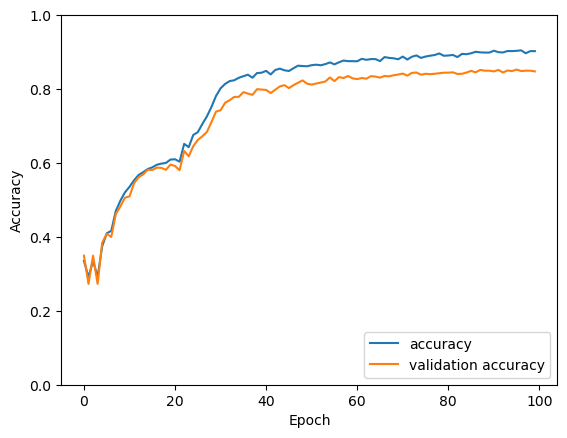

In [63]:
plt.plot(history['train_acc'], label='accuracy')
plt.plot(history['val_acc'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

"""
- batch_size=32, d_k=32, d_v=32, nheads=8, dropout=0.2, SimpleTransformer(2xEncoderLayer), sgd(lr=1e-2, m=0.9)\
-- [Epoch 20] Val Error: Accuracy: 13.6%, Avg loss: 2.022420

- batch_size=32, d_k=16, d_v=16, nheads=8, dropout=0.2, SimpleTransformer(2xEncoderLayer), adam(lr=1e-3)\
-- [Epoch 20] Val Error: Accuracy: 63.9%, Avg loss: 1.053077

- batch_size=32, d_k=8, d_v=8, nheads=4, dropout=0.2, SimpleTransformer(2xEncoderLayer), adam(lr=1e-3)\
-- [Epoch 20] Val Error: Accuracy: 53.8%, Avg loss: 1.320436

- batch_size=32, d_k=16, d_v=16, nheads=4, dropout=0.2, SimpleTransformer(2xEncoderLayer), adam(lr=1e-3)\
-- [Epoch 20] Val Error: Accuracy: 71.9%, Avg loss: 0.814427

- batch_size=32, d_k=12, d_v=12, nheads=6, dropout=0.2, SimpleTransformer(2xEncoderLayer), adam(lr=1e-3)\
-- [Epoch 20] Val Error: Accuracy: 57.9%, Avg loss: 1.196204

- batch_size=32, d_k=8, d_v=8, nheads=2, dropout=0.2, SimpleTransformer(2xEncoderLayer), adam(lr=1e-3)\
-- [Epoch 20] Val Error: Accuracy: 60.2%, Avg loss: 1.012176

- batch_size=32, d_k=8, d_v=8, nheads=2, dropout=0.2, SimpleTransformer(3xEncoderLayer), adam(lr=1e-3)\
-- [Epoch 20] Val Error: Accuracy: 34.9%, Avg loss: 1.582491

- batch_size=32, d_k=16, d_v=16, nheads=4, dropout=0.2, SimpleTransformer(3xEncoderLayer), adam(lr=1e-3)\
-- [Epoch 20] Val Error: Accuracy: 49.6%, Avg loss: 1.399377

- batch_size=32, d_k=64, d_v=64, nheads=16, dropout=0.2, SimpleTransformer(2xEncoderLayer), adam(lr=1e-3)\
-- [Epoch 20] Val Error: Accuracy: 59.9%, Avg loss: 1.017076

- batch_size=32, d_k=64, d_v=64, nheads=32, dropout=0.2, SimpleTransformer(2xEncoderLayer), adam(lr=1e-3)\
-- [Epoch 20] Val Error: Accuracy: 70.4%, Avg loss: 0.801002

- batch_size=32, d_k=128, d_v=128, nheads=64, dropout=0.2, initrange=0.1, SimpleTransformer(2xEncoderLayer), adam(lr=1e-3)\
-- [Epoch 20] Val Error: Accuracy: 71.2%, Avg loss: 0.740802

- batch_size=32, d_k=128, d_v=128, nheads=64, dropout=0.2, initrange=0.01, SimpleTransformer(2xEncoderLayer), adam(lr=1e-3)\
-- [Epoch 20] Val Error: Accuracy: 82.1%, Avg loss: 0.496729

- batch_size=32, d_k=128, d_v=128, nheads=64, dropout=0.3, initrange=0.01, SimpleTransformer(2xEncoderLayer), adam(lr=1e-3)\
-- [Epoch 20] Val Error: Accuracy: 61.4%, Avg loss: 0.977915

- batch_size=64, d_k=128, d_v=128, nheads=64, dropout=0.2, initrange=0.01, SimpleTransformer(2xEncoderLayer), adam(lr=1e-3)\
-- [Epoch 20] Val Error: Accuracy: 57.6%, Avg loss: 1.082794
"""

### 3.3. Evaluation on test set

In [64]:
# Your code to evaluate the final model on the test set here
tokenized_test = tokenize_data(vocab, dataset['test'])
X_test, Y_test = createDataset(model.W1, tokenized_test, dataset['test']['label'], max_len)
test_dataset = CustomDataset4(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32)

transformer.eval()
size = len(test_dataloader) * test_dataloader.batch_size
num_batches = len(test_dataloader)
test_loss, correct = 0, 0

with torch.no_grad():
    for X, Y in test_dataloader:
        pred = transformer(X.to(dev))
        _Y = Y.to(dev)
        test_loss += cross(pred, _Y).item()
        correct += (pred.argmax(dim=1) == _Y.argmax(dim=1)).type(torch.float).sum().item()

test_loss /= num_batches
correct /= size
print(f"Test Error: Accuracy: {(100*(correct)):>0.1f}%, Avg loss: {test_loss:>8f}")

Test Error: Accuracy: 85.8%, Avg loss: 0.396138


In [65]:
torch.save(transformer.state_dict(), 'transformer.torch')

###### ---

## 4. Results and summary

### 4.1 Corpus insights

Corpus is constructed from tweets and each datapoint is labeled with one of the six emotions. Hashtags were used as the groundtruth.

### 4.2 Results

Failure. Failed to surpass accuracy in the paper or reach leaderboard on huggingface website BUT predictions are much better that random guesses. Allthough I reached 26% accuracy when training embeddings, most likely top5 or top3 accuracy was significantly higher. But seeing that embeddings failed to capture meaning, we could not expect transformer perform much better. For improving embeddings main option is to increase dataset size and quality fe. wikipedia. As for improving transformer main methods would be increasing depth of the model by adding more encoder layers. 
\
\
Ultimately I still learned word 2 vec stuff and some transformer theory.

### 4.3 Relation to state of the art

Allthough state of the art used transformer based architecture it outperformed significantly my transformer. Reason for these are model size and dataset size as Bert models are more generic models and trained on far more data and with far more accurate vector representations.

---

## 5. Bonus Task (optional)

### 5.1. Annotating out-of-domain documents

Documents are hand picked comments from r/nba subreddit. The same labels are used here too: sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).\
\
https://www.reddit.com/r/nba/comments/1c610jp/the_golden_state_warriors_have_been_eliminated/
https://www.reddit.com/r/nba/comments/1c8dgt2/highlight_we_want_boston_chants_in_miami/
https://www.reddit.com/r/nba/comments/1c8gsm6/the_sacramento_kings_have_been_eliminated_from/
https://www.reddit.com/r/nba/comments/1c8dsqn/tyler_herro_theyre_obviously_the_best_team_by/
https://www.reddit.com/r/nba/comments/1c8ckvu/scotto_lebron_james_on_nikola_jokic_hes_one_of/
https://www.reddit.com/r/nba/comments/1c8882s/carlin_kelly_oubre_on_playing_at_madison_square/
https://www.reddit.com/r/nba/comments/1c8gsk7/post_game_thread_the_new_orleans_pelicans_take/
https://www.reddit.com/r/nba/comments/1c89oc7/dame_i_saw_somebody_say_dames_not_happy_in/
https://www.reddit.com/r/nba/comments/1c8dos3/the_chicago_bulls_have_been_eliminated_from_2024/
https://www.reddit.com/r/nba/comments/1c8fppy/smith_yuta_watanabe_has_a_26m_player_option_for/
https://www.reddit.com/r/nba/comments/1c8pxx7/the_chicago_bulls_havent_made_a_trade_since_2021/
https://www.reddit.com/r/nba/comments/1c8doov/post_game_thread_the_miami_heat_torch_the_chicago/
https://www.reddit.com/r/nba/comments/1c8dfh0/highlight_new_ucla_cut_variation_just_dropped/


1.  THIS WAS OUR SUPERBOWL (joy)
2. r/nba Christmas came early baby!! (joy)
3. Victory never tasted so sweet (joy)
4. THE WARRIORS HAVE BEEN SENT INTO REBUILD! REJOICE! (joy)
5. Bad Steph turnovers, Klay going 0 for the century, Kuminga not being able to get to the basket, why the fuck was draymond trying to save that ball from going out of bounds, why did we keep letting Murray get open shots? (surprise)
6. Their window closed in such a pathetic way man (anger)
7. Klay was sad to watch man (sadness)
8. Should be a sweep, but Celtics fans will and should be nervous along the way (fear)
9. I did not believe Kings fans when they said they were going to lose to the Zion-less Pelicans (surprise)
10. Disappointing season all things considered. (sadness)
11. This is gonna bite us in the ass (fear)
12. Every bloody fucker on that team showed up big time against us and now everyone except Sabonis ghosts against the Pels. Kings losing pisses me tf off lmao (anger)
13. they lost 6 times. (surprise)
14. (Sad beam noises) (sadness)
15. Pack up the beam! Pack up the beam! (joy)
16. Heat about to do one of the funniest things that’s ever happened in the NBA (joy)
17. He’s one of the best players to ever play this game. It’s that simple (love)
18.  He does everything... When you’re able to inspire your teammates to play at a level that sometimes they don’t even feel like they can play at, that’s a true testament of a great one (love)
19. One thing you can’t say about Lebron is that he hates on his fellow contemporaries (surprise)
20. Worst 23/14/7 I've ever seen (surprise)
21. We're shit talking opponent cities now? (surprise)
22. We're fucked... (fear)
23. He's actually smiled from time to time this season (surprise)
24. And the game that he played was their worst loss (joy)
25. Thanks for the good times Yuta the Shoota o7 (love)
26. Wow. His career earnings are only ~$7M and he's leaving $2.6M on the table. He must really be longing for home (surprise)
27. Good luck to him. Watanabae will always have a place in my heart (love)
28. Once upon a time I was really hoping we would sign him. He kind of got exposed as a shooter when he started shooting a higher volume and his 3 point percentage dropped, but he always gave 110% effort on the court and was fun to watch him hustle. I thought he was going to be a good 3 and D guy but it didn’t really work out (love)
29. sad to see Watanabe leaving the NBA. Best of luck to him in the Olympics this upcoming Summer (love)
30. Loved this dude's positive energy when he was on the Raps. (love)
31. Yuta Watanabe on my wrist! Insane shooter. Thanks for the memories (love)
32. Thank god, it's finally over. Now I can ignore this team that hurts me for the summer and early autumn. (sadness)
33. Jerry Reinsdorf is easily the worst owner in any sport, owns the Bulls and White Sox both in a major market and they both just shit the bed every year. If he wasn’t gifted MJ he would have sold both teams decades ago. (anger)
34. I love the situation that I’m in. I also know what i have going on outside of basketball that kinda drains me at times. (sadness)
35. if i were dame i simply wouldn’t be going through a messy divorce/dealing with determining custody of my three children while trying to win a championship. rip to him but i’m different (surprise)
36. SAS is sports cancer (anger)
37. Stephen A Smith created this rumor because Dame had a bunch of bad games. Dude is out of control with the reckless reporting this season. (anger)
38. This sucks for him. Bitter divorces bring out the absolute worst in everyone. (love)
39. Nothing less than we deserved lol, I thought with Jimmy out we'd manage to make it at least competent. Nope (anger)
40. DeMar DeFraud strikes again. If I had to build a team that would both accomplish nothing and still middle just enough to ensure a mediocre draft pick, my centerpiece would be this guy! (anger)
41. This is extremely low. Dude's out of control with reckless reports this year. At least his other bits like pretending Tatum was MVP favorite until March only made him and ESPN look bad. (sadness)
42. This actually, really hurt to listen to. I went through a divorce after getting a promotion. Was told the same thing by my boss, and others. “Why don’t you seem happy anymore” believing it was them/the promotion. They saw I had a new car, new house, new promotion, everything’s great. Little to their knowledge I was driving to the parking lot over after I got off work to sleep/hang out until the next work day (let her keep the house, told her I was staying at a friends, I never called any friends). You never know what someone is going through, even if you think everything is going right for that person. (sadness)
43. Going sleeveless with a hood on is such a hilarious look (joy)
44. While wnba players are talking down on Caitlin Clark (anger)
45. That was sick. Great pass from Love. (joy)
46. Old man Love has been one of the few bright spots of this season. Grateful he re-signed to take the hardest road this post season. (love)
47. There isn’t a more dangerous team in the league than 15 role players coached by Erik Spoelstra (fear)
48. Damn really? That’s actually pretty crazy (surprise)
49. Pathetic. AK was supposed to be our savior ... (sadness)
50. Ah shit, here we go again (fear)

### 5.2 Conversion into dataset

In [83]:
transformer = SimpleTransformer()
transformer.load_state_dict(torch.load('transformer.torch'))
transformer.eval()
transformer.to(dev)

SimpleTransformer(
  (L0): EncoderLayer(
    (N): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (A): Softmax(dim=1)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (L1): EncoderLayer(
    (N): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (A): Softmax(dim=1)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (L2): EncoderLayer(
    (N): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (A): Softmax(dim=1)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [84]:
import json

In [85]:
with open('bonus.json', 'rb') as f:
    bonus_dataset = json.load(f)

In [86]:
tokenized_bonus = tokenize_data(vocab, bonus_dataset)
X_bonus, Y_bonus = createDataset(model.W1, tokenized_bonus, bonus_dataset['label'], max_len)
bonus_custom_dataset = CustomDataset4(X_bonus, Y_bonus)

### 5.3. Model evaluation on out-of-domain test set

In [87]:
bonus_dataloader = DataLoader(bonus_custom_dataset, batch_size=32)

transformer.eval()
size = len(bonus_dataloader) * bonus_dataloader.batch_size
num_batches = len(bonus_dataloader)
test_loss, correct = 0, 0

with torch.no_grad():
    for X, Y in bonus_dataloader:
        pred = transformer(X.to(dev))
        _Y = Y.to(dev)
        test_loss += cross(pred, _Y).item()
        correct += (pred.argmax(dim=1) == _Y.argmax(dim=1)).type(torch.float).sum().item()

test_loss /= num_batches
correct /= size
print(f"Test Error: Accuracy: {(100*(correct)):>0.1f}%, Avg loss: {test_loss:>8f}")

Test Error: Accuracy: 10.9%, Avg loss: 3.646213


### 5.4 Bonus task results

Results were horrific. Either labels are inaccurate, vocabulary does not cover enough tokens or embeddings are not good enough to represent internet slang.